# Retención de clientes

El objetivo de este notebook es presentar de forma detallada el proceso de desarrollo de un modelo de *Machine Learning* capaz de predecir si un cliente cerrará su cuenta bancaria o continuará siendo cliente de la entidad. El flujo de trabajo abarca desde el análisis exploratorio y el preprocesamiento de los datos hasta el entrenamiento y la evaluación del modelo, con el fin de obtener una solución eficaz para este problema de retención de clientes.

El problema a resolver forma parte de una competición de [Kaggle](https://www.kaggle.com/competitions/retencion-de-clientes-de-una-entidad-financiera/data).

## Librerías utilizadas

Para el desarrollo del modelo de *Machine Learning* se emplean las siguientes librerías:

- [**`Pandas`**](https://pandas.pydata.org/): Manipulación y análisis de datos estructurados.
- [**`NumPy`**](https://numpy.org/): Manejo eficiente de datos numéricos y operaciones matemáticas.
- [**`Matplotlib`**](https://matplotlib.org/): Visualización y análisis gráfico de los datos.
- [**`Seaborn`**](https://seaborn.pydata.org/): Visualización de datos con estilos.
- [**`Scikit-learn`**](https://scikit-learn.org/stable/): Entrenamiento, validación y evaluación de modelos de *Machine Learning*.
- [**`Optuna`**](https://optuna.org/): Estrategias de búsqueda de hiperparámetros.
- [**`XGBoost`**](https://xgboost.readthedocs.io/en/stable/): Algoritmo de aprendizaje automático.
- [**`Imbalanced-learn`**](https://imbalanced-learn.org/stable/): Métodos para el manejo de datos imbalanceados.

In [16]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections.abc import Callable
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

# Modelos
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

## Configuración

En este sección es dónde se definen los parámetros globales para el proyecto.

## Modelos utilizados

- [**`Logistic Regression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Regresión logística.
- [**`Perceptron`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html): Redes perceptrón.
- [**`SVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): Clasificador Support Vector Machine.
- [**`DecisionTree`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html): Árbol de decisión.
- [**`RandomForest`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): Árbol de decisión aleatorio.
- [**`KNeighbors`**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): Clasificador de vecinos.
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html): Clasificador Naive Bayes.  
- [**`MLP`**](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html): Redes neuronales multilayer.
- [**`XGB`**](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier): Clasificador XGBoost.

In [17]:
TARGET = "Exited"  # Variable objetivo
RANDOM_STATE = 42  # Semilla para reproducibilidad
N_TRIALS = 200  # Número de pruebas para Optuna
MIN_ITER = 1000  # Mínimo de iteraciones para modelos que lo requieran
MAX_ITER = 20000  # Máximo de iteraciones para modelos que lo requieran
ITER_STEP = 500  # Paso de iteraciones para modelos que lo requieran
MODELS = [
    "LogisticRegression",
    "Perceptron",
    "SVC",
    "DecisionTree",
    "RandomForest",
    "KNeighbors",
    "GaussianNB",
    "MLP",
    "SGDClassifier",
    "XGB",
    "AdaBoost",
    "GradientBoost",
]

## Exploración

El conjunto de datos cuenta con un total de 10000 registros (80% de entrenamiento y 20% de prueba). Cada registro tiene las siguientes características:

1. Identificación del cliente:

    - `CustomerId`: Identificador único del cliente
    - `Surname`: Apellido del cliente

2. Información financiera:

    - `CreditScore`: Calificación crediticia. Establece la capacidad de una persona para pagar su deuda y el riesgo que conlleva invertir con ella.
    - `Balance`: Saldo en la cuenta bancaria
    - `NumOfProducts`: Número de productos bancarios que utiliza
    - `HasCrCard`: Si tiene tarjeta de crédito (0 = no, 1 = sí)
    - `EstimatedSalary`: Salario estimado

3. Información demográfica y personal:

    - `Geography`: País de residencia
    - `Gender`: Género (Male/Female)
    - `Age`: Edad
    - `Tenure`: Años como cliente del banco
    - `IsActiveMember`: Si es un miembro activo del banco (0 = no, 1 = sí)

4. Variable objetivo:

    - `Exited`: Indicador binario de abandono del banco (0 = se queda, 1 = se va)

In [18]:
# Cargamos los datos
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)
print("Train dataframe")
display(train_df.head())
print("Train dataframe description")
display(train_df.describe())

Train DataFrame shape: (8000, 13)
Test DataFrame shape: (2000, 12)
Train dataframe


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15759244,Boone,687.0,Germany,Male,44,8,95368.14,2.0,1.0,1,1787.85,0
1,15725997,She,660.0,France,Female,35,6,100768.77,1.0,1.0,0,19199.61,0
2,15724296,Kerr,684.0,Spain,Male,41,2,119782.72,2.0,0.0,0,120284.67,0
3,15636820,Loggia,725.0,Germany,Male,40,8,104149.66,1.0,1.0,0,62027.90,0
4,15744529,Chiekwugo,510.0,France,Male,63,8,0.00,2.0,1.0,1,115291.86,0


Train dataframe description


,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8.000000e+03,6359.000000,8000.000000,8000.000000,6385.000000,7024.000000,7625.000000,8000.000000,7168.000000,8000.00000
mean,1.569119e+07,661.235257,38.935000,5.013875,76929.669179,1.539721,0.706623,0.513500,100057.165753,0.20375
std,7.187227e+04,95.876126,10.381389,2.888810,62292.133487,0.574125,0.455340,0.499849,57441.733108,0.40281
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.00000
25%,1.562896e+07,595.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51545.352500,0.00000
50%,1.569112e+07,664.000000,37.000000,5.000000,98009.130000,2.000000,1.000000,1.000000,100129.075000,0.00000
75%,1.575373e+07,729.000000,44.000000,8.000000,127660.460000,2.000000,1.000000,1.000000,149216.320000,0.00000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.00000


In [19]:
# Información general
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       8000 non-null   int64  
 1   Surname          7591 non-null   object 
 2   CreditScore      6359 non-null   float64
 3   Geography        8000 non-null   object 
 4   Gender           8000 non-null   object 
 5   Age              8000 non-null   int64  
 6   Tenure           8000 non-null   int64  
 7   Balance          6385 non-null   float64
 8   NumOfProducts    7024 non-null   float64
 9   HasCrCard        7625 non-null   float64
 10  IsActiveMember   8000 non-null   int64  
 11  EstimatedSalary  7168 non-null   float64
 12  Exited           8000 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 812.6+ KB


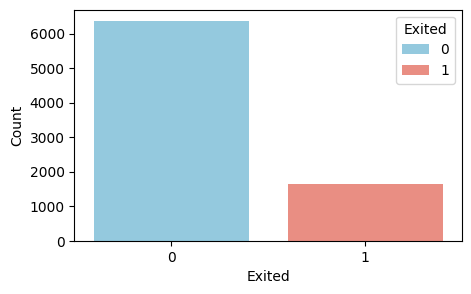

In [20]:
# Distribución de la variable objetivo
plt.figure(figsize=(5, 3))
sns.countplot(x=TARGET, data=train_df, palette=["skyblue", "salmon"], hue=TARGET)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.show()

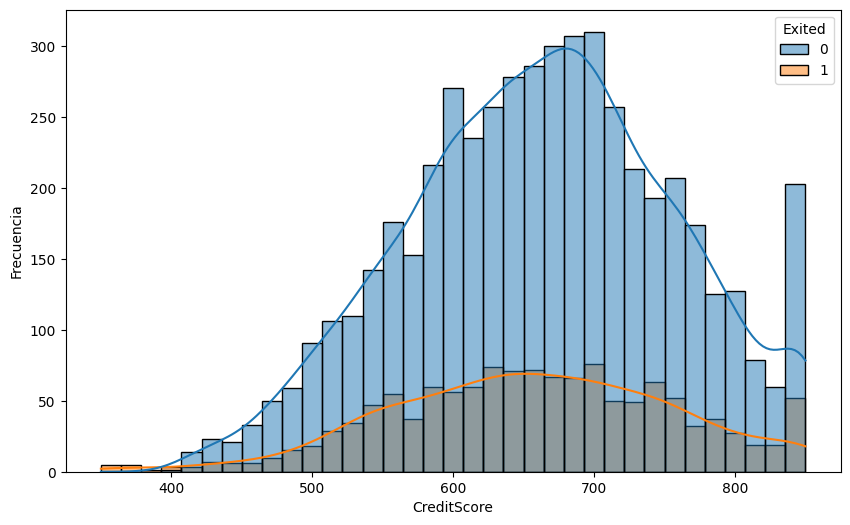

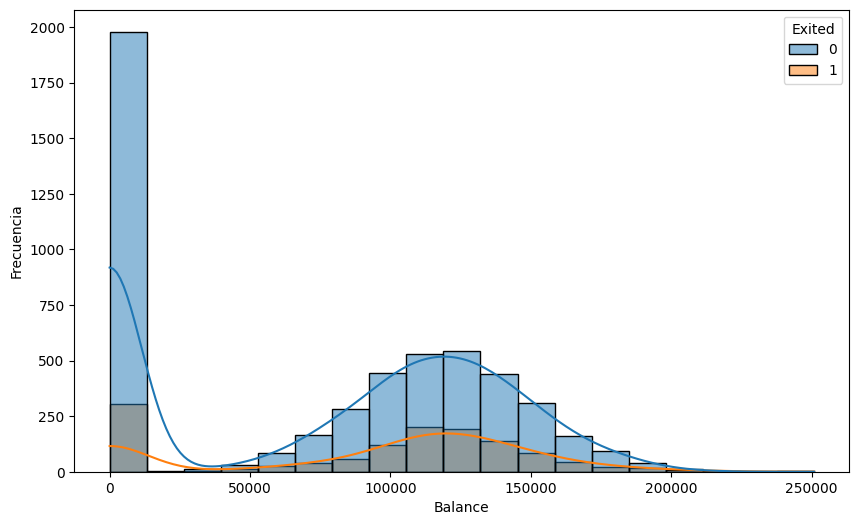

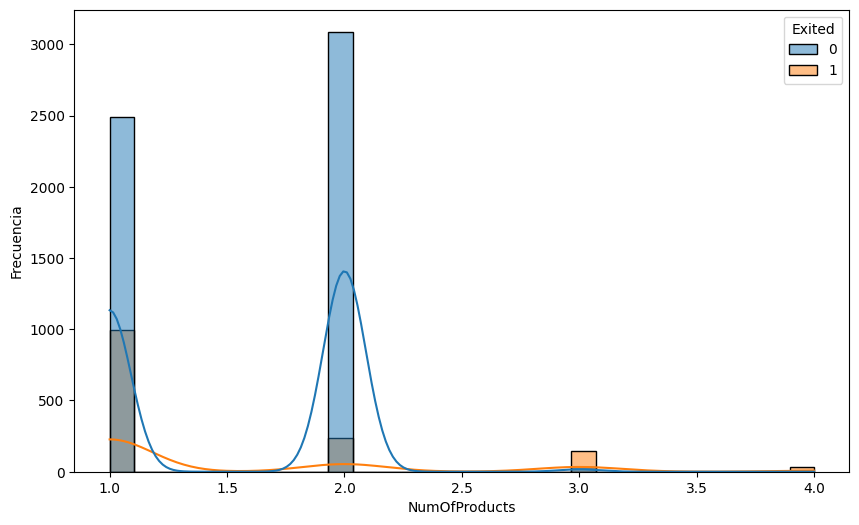

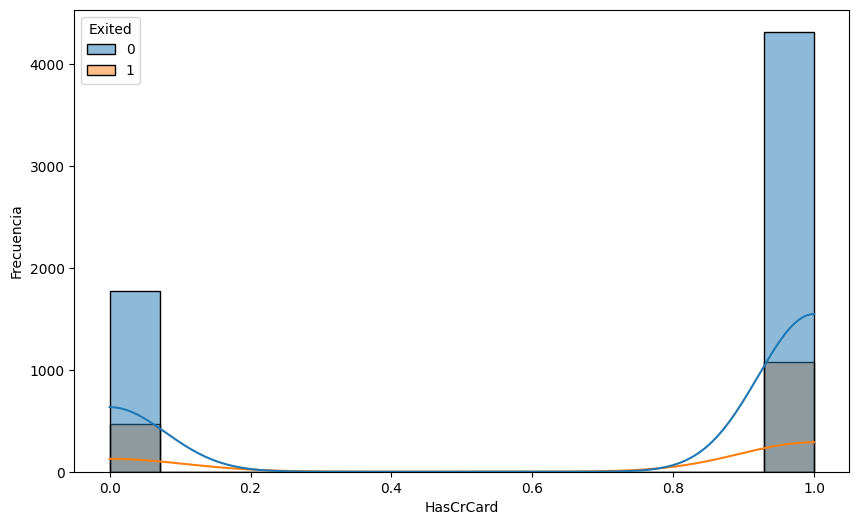

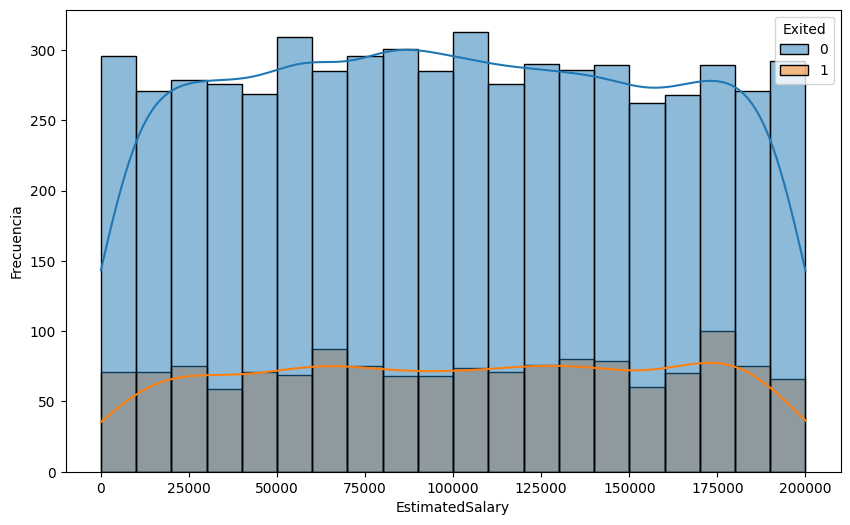

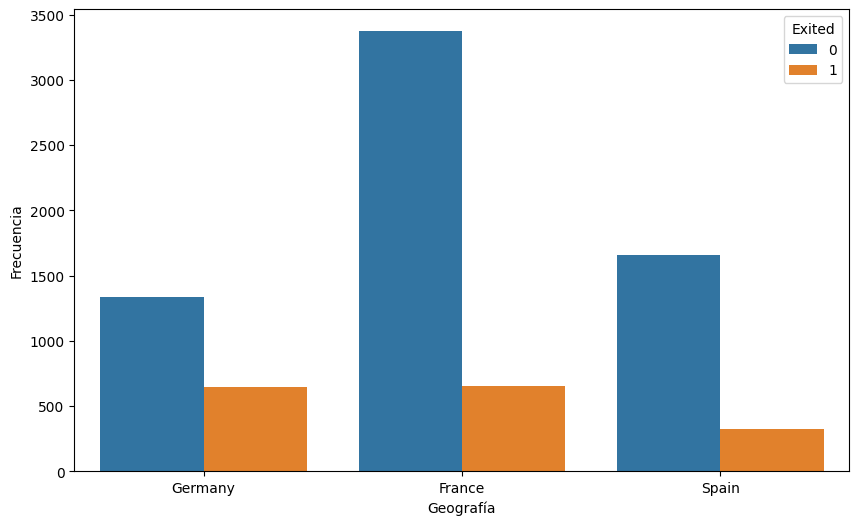

In [25]:
# Distibución de caraterística bancarias por Exited
bank_feats = ["CreditScore", "Balance", "NumOfProducts", "HasCrCard", "EstimatedSalary"]
for col in bank_feats:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_df, x=col, hue=TARGET, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(False)
    plt.show()

# Frecuancia de País y Excited
plt.figure(figsize=(10, 6))
sns.countplot(x="Geography", data=train_df, hue=TARGET)
plt.xlabel("Geografía")
plt.ylabel("Frecuencia")
plt.show()

In [22]:
# Características numéricas
all_num_feats = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_feats = [
    col
    for col in all_num_feats
    if col not in ["CustomerId", "Exited", "HasCrCard", "IsActiveMember"]
]
print(f"Características numéricas: {num_feats}")

# Características categóricas
cat_feats = train_df.select_dtypes(include=[np.object_, "category"]).columns.tolist()
cat_feats = [col for col in cat_feats if col not in ["Surname"]]
print(f"Características categóricas: {cat_feats}")

Características numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
Características categóricas: ['Geography', 'Gender']


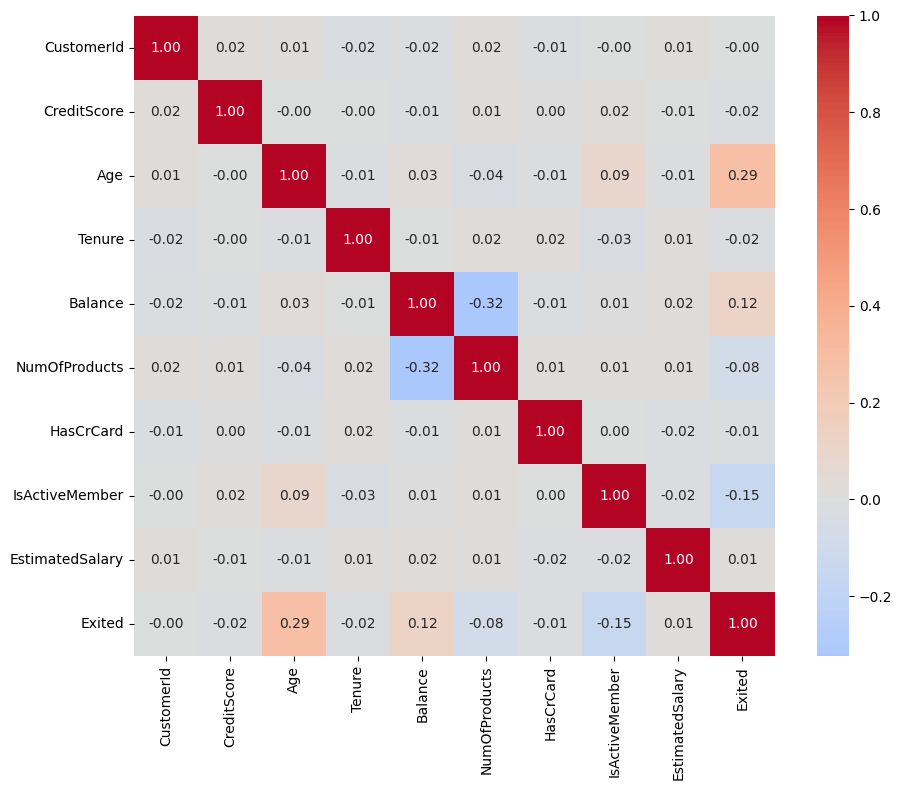

In [23]:
# Matriz de correlación para variables numéricas
num_data = train_df[all_num_feats]
corr_matrix = num_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.tight_layout()
plt.show()

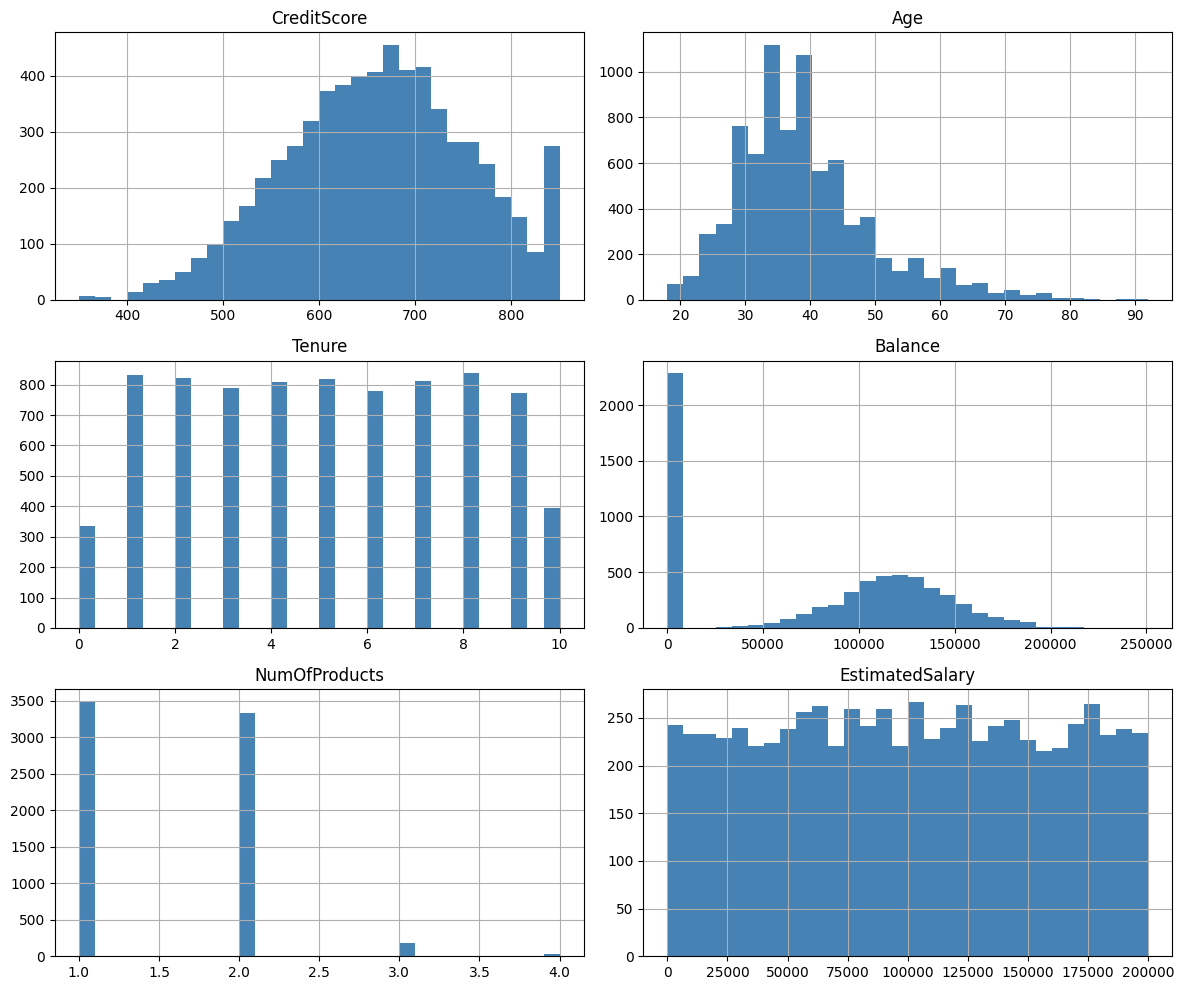

In [24]:
# Histogramas
train_df[num_feats].hist(figsize=(12, 10), bins=30, color="steelblue")
plt.tight_layout()
plt.show()

## Preprocesamiento

En esta sección se realiza el preprocesamiento de los datos para que estos puedan ser utilizados en el modelo.

- Imputación de valores faltantes (mediante la media de los valores de la columna)
- Normalización de los datos númericos (StandardScaler)
- One-hot encoding de las categorías
- Selección de características (SelectKBest)
- Creación de nuevas características (BalancePerProduct (Balance / Product), o Edad categórica (Joven, Adulto, Senior))??

In [10]:
# Valores nulos en el conjunto de entrenamiento y test
nan_columns = train_df.isnull().sum()
print(f"Valores nulos en el conjunto de entrenamiento:\n{nan_columns}\n")

Valores nulos en el conjunto de entrenamiento:
CustomerId            0
Surname             409
CreditScore        1641
Geography             0
Gender                0
Age                   0
Tenure                0
Balance            1615
NumOfProducts       976
HasCrCard           375
IsActiveMember        0
EstimatedSalary     832
Exited                0
dtype: int64



In [11]:
def add_feats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["BalancePerProduct"] = df["Balance"] / (df["NumOfProducts"].fillna(0) + 1)
    df["BalancePerSalary"] = df["Balance"] / (df["EstimatedSalary"] + 1)

    df["AgeBucket"] = pd.cut(df["Age"], bins=[0, 30, 45, 60, 120], labels=False)

    df["CreditScore_x_Age"] = df["CreditScore"] * df["Age"]

    df["HasCrCard"] = df["HasCrCard"].fillna(0).astype(int)
    df["IsActiveMember"] = df["IsActiveMember"].astype(int)

    return df


# Añadir nuevas características
train_df = add_feats(train_df)
test_df = add_feats(test_df)

In [12]:
# Características numéricas
num_feats = train_df.select_dtypes(include=[np.number]).columns.tolist()
binary_features = ["HasCrCard", "IsActiveMember"]
num_feats = [
    col
    for col in num_feats
    if col not in ["CustomerId", "Exited"] and col not in binary_features
]

# Características categóricas
cat_feats = train_df.select_dtypes(include=[np.object_, "category"]).columns.tolist()
cat_feats = [col for col in cat_feats if col not in ["Surname"]]

print(f"Características numéricas: {num_feats}")
print(f"Características binarias: {binary_features}")
print(f"Características categóricas: {cat_feats}")

Características numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'BalancePerProduct', 'BalancePerSalary', 'AgeBucket', 'CreditScore_x_Age']
Características binarias: ['HasCrCard', 'IsActiveMember']
Características categóricas: ['Geography', 'Gender']


In [ ]:
# Preprocesamiento para variables numéricas
num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
# Preprocesamiento para variables categóricas-
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)
# Preprocesamiento para las variables binarias
bin_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_feats),
        ("cat", cat_pipeline, cat_feats),
        ("bin", bin_pipeline, binary_features),
    ]
)

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e

## Modelo

Se realizará una validación cruzada sobre los modelos para obtener el que mejor se ajusta al conjunto de datos (en este caso, el que mejor f1 score consiga). Una vez se obtenga el mejor modelo, ser realizará un optimización de los hiperparámetros para optimizarlo lo mejor posible.

In [14]:
def get_model_space(
    name: str, trial: optuna.Trial | optuna.trial.FixedTrial
) -> BaseEstimator | None:
    match name:
        case "LogisticRegression":
            c = trial.suggest_float("lr_c", 1e-4, 10, log=True)
            max_iter = trial.suggest_int(
                "lr_max_iter", MIN_ITER, MAX_ITER, step=ITER_STEP
            )
            return LogisticRegression(C=c, random_state=RANDOM_STATE, max_iter=max_iter)
        case "Perceptron":
            penalty = trial.suggest_categorical(
                "perc_penalty", ["l2", "l1", "elasticnet"]
            )
            alpha = trial.suggest_float("perc_alpha", 1e-5, 1e-2, log=True)
            max_iter = trial.suggest_int(
                "perc_max_iter", MIN_ITER, MAX_ITER, step=ITER_STEP
            )
            return Perceptron(
                penalty=penalty,  # type: ignore
                alpha=alpha,
                max_iter=max_iter,
                random_state=RANDOM_STATE,
            )
        case "SVC":
            c = trial.suggest_float("svc_c", 1e-3, 10.0, log=True)
            kernel = trial.suggest_categorical("svc_kernel", ["linear", "rbf"])
            return SVC(
                C=c,
                kernel=kernel,  # type: ignore
                probability=True,
                random_state=RANDOM_STATE,
                max_iter=-1,
            )
        case "DecisionTree":
            max_depth = trial.suggest_int("dt_max_depth", 2, 32)
            min_split = trial.suggest_int("dt_min_split", 2, 20)
            return DecisionTreeClassifier(
                max_depth=max_depth,
                min_samples_split=min_split,
                random_state=RANDOM_STATE,
            )
        case "RandomForest":
            n_est = trial.suggest_int("rf_n_estimators", 50, 300)
            max_depth = trial.suggest_int("rf_max_depth", 2, 32)
            return RandomForestClassifier(
                n_estimators=n_est,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=RANDOM_STATE,
            )
        case "KNeighbors":
            n_neighbors = trial.suggest_int("knn_n_neighbors", 3, 20)
            weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])
            return KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights,  # type: ignore
                n_jobs=-1,
            )
        case "GaussianNB":
            var_smoothing = trial.suggest_float(
                "gnb_var_smoothing", 1e-9, 1e-5, log=True
            )
            return GaussianNB(var_smoothing=var_smoothing)
        case "MLP":
            layers_label = trial.suggest_categorical(
                "mlp_layers", ["layer_50", "layer_100", "layer_50_50", "layer_100_100"]
            )
            layers_map = {
                "layer_50": (50,),
                "layer_100": (100,),
                "layer_50_50": (50, 50),
                "layer_100_100": (100, 100),
            }
            alpha = trial.suggest_float("mlp_alpha", 1e-5, 1e-2, log=True)
            max_iter = trial.suggest_int(
                "mlp_max_iter", MIN_ITER, MAX_ITER, step=ITER_STEP
            )
            return MLPClassifier(
                hidden_layer_sizes=layers_map[layers_label],
                alpha=alpha,
                max_iter=max_iter,
                random_state=RANDOM_STATE,
            )
        case "SGDClassifier":
            loss = trial.suggest_categorical(
                "sgd_loss",
                ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"],
            )
            penalty = trial.suggest_categorical(
                "sgd_penalty", ["l2", "l1", "elasticnet"]
            )
            alpha = trial.suggest_float("sgd_alpha", 1e-5, 1e-2, log=True)
            max_iter = trial.suggest_int(
                "sgd_max_iter", MIN_ITER, MAX_ITER, step=ITER_STEP
            )
            return SGDClassifier(
                loss=loss,  # type: ignore
                penalty=penalty,  # type: ignore
                alpha=alpha,
                max_iter=max_iter,
                random_state=RANDOM_STATE,
            )
        case "XGB":
            n_est = trial.suggest_int("xgb_n_estimators", 50, 300)
            max_depth = trial.suggest_int("xgb_max_depth", 2, 10)
            lr = trial.suggest_float("xgb_lr", 0.01, 0.3, log=True)
            return XGBClassifier(
                n_estimators=n_est,
                max_depth=max_depth,
                learning_rate=lr,
                objective="binary:logistic",
                n_jobs=-1,
                random_state=RANDOM_STATE,
                verbosity=0,
            )
        case "AdaBoost":
            n_est = trial.suggest_int("adb_n_estimators", 50, 300)
            lr = trial.suggest_float("adb_lr", 0.01, 1.0, log=True)
            return AdaBoostClassifier(
                n_estimators=n_est,
                learning_rate=lr,
                random_state=RANDOM_STATE,
            )
        case "GradientBoost":
            n_est = trial.suggest_int("gb_n_estimators", 50, 300)
            lr = trial.suggest_float("gb_lr", 0.01, 1.0, log=True)
            return GradientBoostingClassifier(
                n_estimators=n_est,
                learning_rate=lr,
                random_state=RANDOM_STATE,
            )
        case _:
            raise ValueError(f"Model {name} not found in {MODELS}")


def save_models_evals(study: optuna.study.Study, path: str) -> None:
    records = {}

    for trial in study.trials:
        if trial.value is None:
            continue

        clf_name = trial.params["clf"]
        score = trial.value
        if clf_name not in records or score > records[clf_name]:
            records[clf_name] = score

    df = pd.DataFrame([{"Model": k, "Score": v} for k, v in records.items()])
    df.to_csv(path, index=False)


def select_best_model(
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5,
    eval_metric: Callable = f1_score,
    evals_path: str | None = "models_evals.csv",
) -> tuple[Pipeline, float]:
    def objective(trial: optuna.Trial) -> float:
        clf_name = trial.suggest_categorical("clf", MODELS)

        clf = get_model_space(clf_name, trial)
        k_feats = trial.suggest_int("k_best", 2, X.shape[1])

        model = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("balancer", SMOTE(random_state=RANDOM_STATE)),
                ("feat_select", SelectKBest(score_func=f_classif, k=k_feats)),
                ("clf", clf),
            ]
        )

        cv_strategy = StratifiedKFold(
            n_splits=cv, shuffle=True, random_state=RANDOM_STATE
        )

        score = cross_val_score(
            model,
            X,
            y,
            cv=cv_strategy,
            scoring=make_scorer(eval_metric),
            n_jobs=-1,
        ).mean()

        return score

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS)

    if evals_path is not None:
        save_models_evals(study, evals_path)

    best_params = study.best_params.copy()
    best_clf_name = best_params.pop("clf")
    best_k = best_params.pop("k_best")
    best_clf = get_model_space(best_clf_name, optuna.trial.FixedTrial(best_params))

    print(
        f"Best trial score ({eval_metric.__name__}) for {best_clf_name}: {study.best_value:.4f}"
    )

    final_model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("balancer", SMOTE(random_state=RANDOM_STATE)),
            ("feat_select", SelectKBest(score_func=f_classif, k=best_k)),
            ("clf", best_clf),
        ]
    )

    return final_model, study.best_value


X = train_df.drop(columns=[TARGET, "CustomerId", "Surname"])
y = train_df[TARGET]

best_model, score = select_best_model(X, y)
with open("scores.txt", "a") as f:
    f.write(f"{best_model[-1].__class__.__name__}: {score:.4f}\n")
best_model

/home/pacatro/Code/master/CdD/client_retention/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/pacatro/Code/master/CdD/client_retention/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best trial score (f1_score) for GradientBoost: 0.6044


,steps,"[('preprocessor', ...), ('balancer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatt

## Predicción

In [15]:
print(f"Using {best_model[-1].__class__.__name__} to predict on test set")
best_model.fit(X, y)
preds = best_model.predict(test_df.drop(columns=["CustomerId", "Surname"], axis=1))
results_df = pd.DataFrame()
results_df["CustomerId"] = test_df["CustomerId"]
results_df["Exited"] = preds
results_df.head()

Using GradientBoostingClassifier to predict on test set


,CustomerId,Exited
0,15764618,0
1,15626385,0
2,15687413,0
3,15759067,1
4,15614049,0


In [16]:
results_df.to_csv("submission.csv", index=False)